# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload

# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

model_source_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled/model_steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/'
example_data_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

# load parpe module from source tree
sys.path.insert(0, os.path.join(parpe_source_root, 'python'))
import parpe

In [2]:
# rebuild example
!cd {parpe_build_root} && make

[  9%] Built target parpecommon
[ 20%] Built target parpeoptimization
[ 23%] Built target parpeloadbalancer
[ 35%] Built target parpeamici
[ 36%] Built target parpe
-- Found Git: /usr/bin/git (found version "2.20.1") 
-- Building version parPE-v0.2.1-102-g1a290-dirty
[ 36%] Built target get_version
[ 42%] Built target unittests_common
[ 47%] Built target unittests_loadbalancer
[ 54%] Built target unittests_optimization
Setting up virtual environment...
[ 54%] Built target setup_venv
[ 55%] Creating test data using hierarchicalOptimizationTest.py
...
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
[ 55%] Built target prepare_test_hierarchical_optimization
[ 63%] Built target unittests_amici
[ 65%] Built target example_loadbalancer
[ 76%] Built target steadystate_scaled
[ 79%] Built target example_steadystate_multi_simulator
[ 85%] Built target example_steadystate_parallel
[ 89%] Built target example_steadystate_multi
[ 92%] Built target e

In [ ]:
# run make test to generated all output files required below
!cd {parpe_build_root} && make test

## Test simulation

In [7]:
# load model
sys.path.insert(0, model_source_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

[1.  0.5 0.4 2.  0.1 0.2 0.2 0.2 2.  0.2 3.  0.2 0.2]


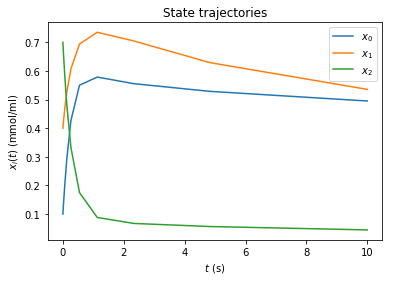

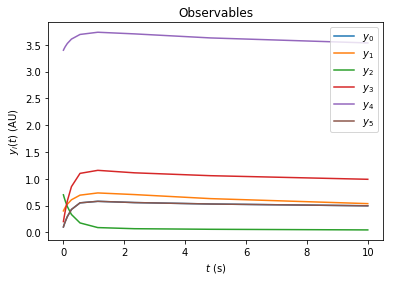

In [8]:
from amici.plotting import plotStateTrajectories
from amici.plotting import plotObservableTrajectories

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)

## Set parameter estimation options

Test data is:
- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [9]:
# enable derivate checker
input_file = f'{example_data_dir}/example_data.h5'
#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test first-order
#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test_print_all yes
!{optimizationOptionsPy} {input_file} -s numStarts 2
!{optimizationOptionsPy} {input_file} -s hierarchicalOptimization 0
!{optimizationOptionsPy} {input_file}


                hierarchicalOptimization            0
                               numStarts            2
                               optimizer            0
                       retryOptimization            1
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-12
                    ipopt/acceptable_tol        1e+20
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

## Gradient check

In [10]:
for i in range(3):
    !PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {input_file}
    print()


[2019-04-10 13:35:23] [INF] [-1/]     0 g: -1.07354e+13  fd_c: -1.07357e+13  Δ/ff: 1.986214e-05  f:  1.85802e+13
[2019-04-10 13:35:23] [INF] [-1/]     1 g:  -1.0624e+13  fd_c: -1.06233e+13  Δ/ff: -4.084544e-05  f:  1.85802e+13
[2019-04-10 13:35:23] [INF] [-1/]     2 g:  1.07107e+13  fd_c:  1.07095e+13  Δ/ff: 6.760467e-05  f:  1.85805e+13
[2019-04-10 13:35:23] [INF] [-1/]     3 g:  2.74812e+12  fd_c:  2.74869e+12  Δ/ff: -3.077967e-05  f:  1.85804e+13
[2019-04-10 13:35:23] [INF] [-1/]     4 g:  2.04872e+13  fd_c:  2.04874e+13  Δ/ff: -1.101963e-05  f:  1.85805e+13
[2019-04-10 13:35:23] [INF] [-1/]     5 g:  4.02306e+13  fd_c:  4.02306e+13  Δ/ff: -7.451039e-10  f:  1.85807e+13
[2019-04-10 13:35:23] [INF] [-1/]     6 g:    2.575e+08  fd_c:    2.575e+08  Δ/ff: 3.861851e-12  f:  1.85803e+13
[2019-04-10 13:35:23] [INF] [-1/]     7 g: -4.14679e+06  fd_c: -4.14687e+06  Δ/ff: 4.504851e-12  f:  1.85803e+13
[2019-04-10 13:35:23] [INF] [-1/]     8 g:  9.83746e+07  fd_c:  9.83746e+07  Δ/ff: 1.485753e

## Optimize

In [11]:
!pwd
!(cd {parpe_build_root} && exec make -j12)
!rm -rf deleteme
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -o deleteme/ {example_data_dir}/example_data.h5


/home/dweindl/src/parPE_2/examples/parpeamici/steadystate
Setting up virtual environment...
-- Found Git: /usr/bin/git (found version "2.20.1") 
[  9%] Built target parpecommon
-- Building version parPE-v0.2.1-102-g1a290-dirty
[  9%] Built target setup_venv
[ 13%] Built target parpeloadbalancer
[ 13%] Built target get_version
[ 19%] Built target unittests_common
[ 20%] Creating test data using hierarchicalOptimizationTest.py
[ 30%] Built target parpeoptimization
[ 35%] Built target unittests_loadbalancer
[ 38%] Built target example_loadbalancer
[ 45%] Built target unittests_optimization
[ 57%] Built target parpeamici
[ 58%] Built target parpe
[ 69%] Built target steadystate_scaled
...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK
[ 72%] Built target example_steadystate_multi
[ 79%] Built target test_steadystate
[ 83%] Built target example_steadystate_multi_simulator
[ 86%] Built target example_steadystate
[ 92%] Built target example_st

[2019-04-10 13:35:27] [INF] [-1/] [o0i7] iter: 7 cost: -357.965 time_iter: wall: 0.0603872s cpu: 0.177068s time_optim: wall: 0.578761s cpu: 1.72704s
   7 -3.5796483e+02 0.00e+00 7.30e-01  -6.1 1.98e-02    -  1.00e+00 1.00e+00f  1
[2019-04-10 13:35:27] [INF] [-1/] [o1i7] iter: 7 cost: -357.965 time_iter: wall: 0.0566234s cpu: 0.181906s time_optim: wall: 0.587907s cpu: 1.78966s
   7 -3.5796483e+02 0.00e+00 7.30e-01  -6.1 1.98e-02    -  1.00e+00 1.00e+00f  1
[2019-04-10 13:35:27] [INF] [-1/] [o0i8] iter: 8 cost: -358.541 time_iter: wall: 0.0715295s cpu: 0.191683s time_optim: wall: 0.65029s cpu: 1.91872s
   8 -3.5854104e+02 0.00e+00 1.97e+00  -7.8 6.41e-02    -  1.00e+00 5.00e-01f  2
[2019-04-10 13:35:27] [INF] [-1/] [o1i8] iter: 8 cost: -358.541 time_iter: wall: 0.0705077s cpu: 0.194492s time_optim: wall: 0.658415s cpu: 1.98416s
   8 -3.5854104e+02 0.00e+00 1.97e+00  -7.8 6.41e-02    -  1.00e+00 5.00e-01f  2
[2019-04-10 13:35:27] [INF] [-1/] [o0i9] iter: 9 cost: -358.771 time_iter: wall: 

[2019-04-10 13:35:28] [INF] [-1/] [o1i23] iter: 23 cost: -363.56 time_iter: wall: 0.0812804s cpu: 0.196409s time_optim: wall: 1.65869s cpu: 4.69971s
  23 -3.6355992e+02 0.00e+00 3.60e-01 -11.0 5.74e-01    -  1.00e+00 6.25e-02f  5
[2019-04-10 13:35:28] [INF] [-1/] [o0i24] iter: 24 cost: -363.562 time_iter: wall: 0.0872275s cpu: 0.192329s time_optim: wall: 1.71829s cpu: 4.78004s
  24 -3.6356237e+02 0.00e+00 6.15e-01 -11.0 6.80e-01    -  1.00e+00 3.12e-02f  6
[2019-04-10 13:35:28] [INF] [-1/] [o1i24] iter: 24 cost: -363.562 time_iter: wall: 0.0957775s cpu: 0.20271s time_optim: wall: 1.75447s cpu: 4.90242s
  24 -3.6356224e+02 0.00e+00 6.22e-01 -11.0 6.81e-01    -  1.00e+00 3.12e-02f  6
[2019-04-10 13:35:28] [INF] [-1/] [o0i25] iter: 25 cost: -363.58 time_iter: wall: 0.0704364s cpu: 0.178181s time_optim: wall: 1.78873s cpu: 4.95822s
  25 -3.6358034e+02 0.00e+00 2.77e-01 -11.0 4.37e-02    -  1.00e+00 5.00e-01f  2
[2019-04-10 13:35:28] [INF] [-1/] [o1i25] iter: 25 cost: -363.581 time_iter: wa

[2019-04-10 13:35:30] [INF] [-1/] [o0i40] iter: 40 cost: -363.644 time_iter: wall: 0.0847426s cpu: 0.196958s time_optim: wall: 3.01587s cpu: 7.91694s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -3.6364410e+02 0.00e+00 1.26e-03 -11.0 1.24e-04    -  1.00e+00 6.25e-02f  5
[2019-04-10 13:35:30] [INF] [-1/] [o1i41] iter: 41 cost: -363.644 time_iter: wall: 0.0719409s cpu: 0.165025s time_optim: wall: 3.06873s cpu: 8.11045s
  41 -3.6364410e+02 0.00e+00 2.05e-03 -11.0 1.77e-04    -  1.00e+00 2.50e-01f  3
[2019-04-10 13:35:30] [INF] [-1/] [o0i41] iter: 41 cost: -363.644 time_iter: wall: 0.0988346s cpu: 0.238539s time_optim: wall: 3.1147s cpu: 8.15548s
  41 -3.6364410e+02 0.00e+00 1.21e-03 -11.0 2.24e-03    -  1.00e+00 3.91e-03f  9
[2019-04-10 13:35:30] [INF] [-1/] [o1i42] iter: 42 cost: -363.644 time_iter: wall: 0.0687784s cpu: 0.197186s time_optim: wall: 3.13751s cpu: 8.30764s
  42 -3.6364410e+02 0.00e+00 6.72e-04 -11.0 1.21e-03    -  1.00e+00 1.25e-01f

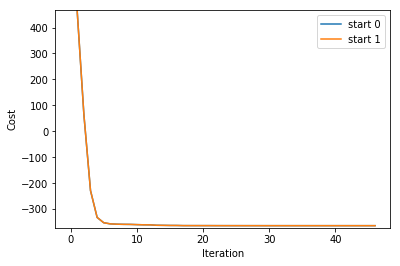

In [15]:
filename = 'deleteme/_rank00000.h5'
trajectories = parpe.getCostTrajectories(filename)
#print(repr(trajectories))
parpe.plotting.plotCostTrajectory(trajectories, log=False);

## Compare results

In [19]:
def compareResults(filename):
    with h5py.File(filename, 'r') as f:
        pscale = f['/inputData/parameters/pscaleOptimization'][:]
        names = f['/inputData/parameters/parameterNames'][:]
        true_parameters = f['/inputData/parameters/true_parameters'][:]
        expectedNllh = -f['/inputData/parameters/true_llh'][:]
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %9.5f %11.5f %11.5f %11.5f %s' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error, names[i]))
    print()
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [20]:
compareResults('deleteme/_rank00000.h5')

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     1.06611     0.06611     0.06611 p1
1:   0.50000     0.40152    -0.09848    -0.19695 p2
2:   0.40000     0.46440     0.06440     0.16099 p3
3:   2.00000     2.07965     0.07965     0.03983 p4
4:   0.10000     0.06826    -0.03174    -0.31737 p5
5:   2.00000     1.91826    -0.08174    -0.04087 scaling_x1_common
6:   3.00000     2.99601    -0.00399    -0.00133 offset_x2_batch-0
7:   0.20000     0.19761    -0.00239    -0.01197 x1withsigma_sigma
8:   4.00000     2.97014    -1.02986    -0.25747 offset_x2_batch-1

Status: 4
Cost: -363.644104 (expected: -0.000000)


In [21]:
# Simulate with optimal parameters, save results
!rm sim.h5
!{example_binary_dir}/example_steadystate_multi_simulator deleteme/_rank00000.h5 / sim.h5 / --at-optimum

rm: cannot remove 'sim.h5': No such file or directory
Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Need to compute analytical parameters: //inputData  1 parameters.size() == 5 ; hierarchical.numParameters() == 5
Starting simulation. Number of conditions: 4
Running for start 1
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Need to compute analytical parameters: //inputData  1 parameters.size() == 5 ; hierarchical.numParameters() == 5
Starting simulation. Number of conditions: 4


In [22]:
# Load simulated outputs
with h5py.File('deleteme/_rank00000.h5', 'r') as f:
    timepoints = f['/inputData/amiciOptions/ts'][:]

with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
    
print(ysim.shape)
print(ymes.shape)

AttributeError: 'slice' object has no attribute 'encode'

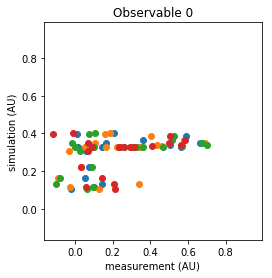

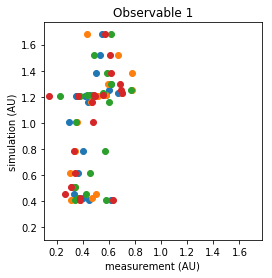

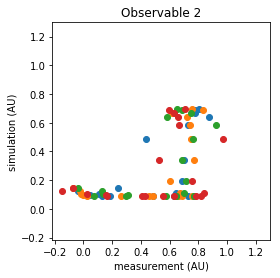

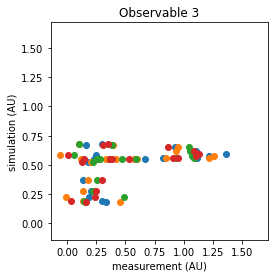

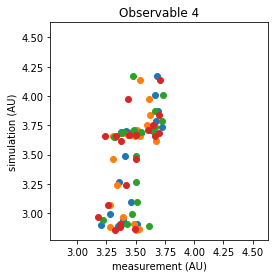

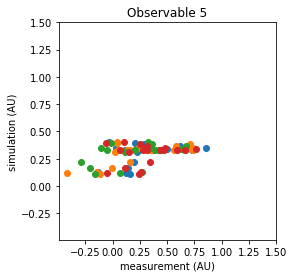

In [47]:
parpe.plotting.plotCorrelations(ymes, ysim)

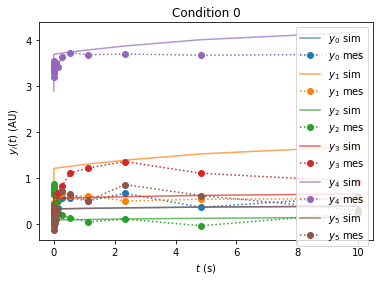

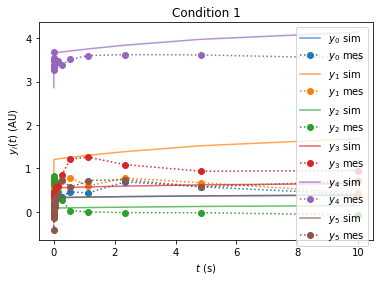

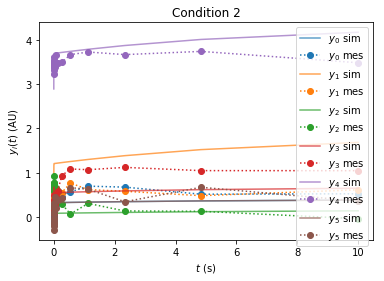

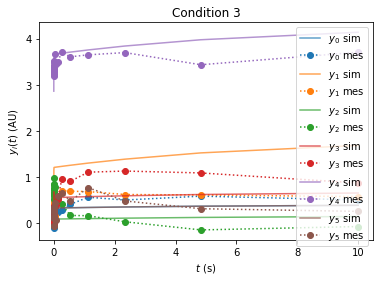

In [48]:
parpe.plotting.plotTrajectoryFits(ymes, ysim, timepoints)

## Hierarchical optimization

In [23]:
hdf5_input_file_hierarchical = f'{example_data_dir}/example_data.h5'
hdf5_pe_output_file_hierarchical = 'deletemehierarchical/_rank00000.h5'
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s hierarchicalOptimization 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s numStarts 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/max_iter 20
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_obj_change_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5_input_file_hierarchical}


                hierarchicalOptimization            1
                               numStarts            1
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

In [24]:
# gradient check 
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {hdf5_input_file_hierarchical}


HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
scalings [ -0.703488 ]
sigmas [ 0.373854 ]
scalings [ -0.703484 ]
sigmas [ 0.373849 ]
scalings [ -0.703493 ]
sigmas [ 0.373859 ]
[2019-04-10 13:38:21] [INF] [-1/]     0 g:  5.36159e+07  fd_c:  5.35597e+07  Δ/ff: 5.650856e-04  f:  9.94925e+07
scalings [ -0.703487 ]
sigmas [ 0.373853 ]
scalings [ -0.703489 ]
sigmas [ 0.373855 ]
[2019-04-10 13:38:21] [INF] [-1/]     1 g: -1.04435e+08  fd_c: -1.04462e+08  Δ/ff: 2.747021e-04  f:  9.94909e+07
scalings [ -0.703493 ]
sigmas [ 0.373859 ]
scalings [ -0.703484 ]
sigmas [ 0.373849 ]
[2019-04-10 13:38:21] [INF] [-1/]     2 g: -5.36057e+07  fd_c: -5.36374e+07  Δ/ff: 3.191502e-04  f:  9.94914e+07
scalings [ -0.703489 ]
sigmas [ 0.373855 ]
scalings [ -0.703487 ]
sigmas [ 0.373853 ]
[2019-04-10 13:38:21] [INF] [-1/]     3 g:  1.04344e+08  fd_c:  1.04376e+08  Δ/ff: -3.247765e-04  f:   9.9493e+07
scalings [ -0.703493 ]
sigmas [ 0.373859 ]
scalings [ -0.

In [25]:
# optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemehierarchical/ {hdf5_input_file_hierarchical}


[2019-04-10 13:38:22] [INF] [0/dweindl-ThinkPad-L480] Running with 4 MPI processes.
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-04-10 13:38:22] [INF] [0/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol =

[2019-04-10 13:38:23] [INF] [0/dweindl-ThinkPad-L480] [o0i14] iter: 14 cost: -363.644 time_iter: wall: 0.0878381s cpu: 0.17028s time_optim: wall: 1.06718s cpu: 2.4867s
  14 -3.6364358e+02 0.00e+00 2.50e-01 -11.0 8.47e-03    -  1.00e+00 1.25e-01f  4
scalings [ 0.282817 ]
sigmas [ -0.704201 ]
scalings [ 0.282817 ]
sigmas [ -0.704201 ]
[2019-04-10 13:38:23] [INF] [0/dweindl-ThinkPad-L480] [o0i15] iter: 15 cost: -363.644 time_iter: wall: 0.0586932s cpu: 0.143545s time_optim: wall: 1.12587s cpu: 2.63024s
  15 -3.6364402e+02 0.00e+00 6.79e-02 -11.0 4.70e-03    -  1.00e+00 1.00e+00f  1
scalings [ 0.28322 ]
sigmas [ -0.704182 ]
scalings [ 0.28322 ]
sigmas [ -0.704182 ]
scalings [ 0.283018 ]
sigmas [ -0.704192 ]
scalings [ 0.282918 ]
sigmas [ -0.704196 ]
scalings [ 0.282867 ]
sigmas [ -0.704198 ]
scalings [ 0.282867 ]
sigmas [ -0.704198 ]
[2019-04-10 13:38:23] [INF] [0/dweindl-ThinkPad-L480] [o0i16] iter: 16 cost: -363.644 time_iter: wall: 0.0869808s cpu: 0.168878s time_optim: wall: 1.21285s cp

array([[-336.44886831, -355.58421008, -361.7219826 , -362.04489288,
        -362.12904592, -362.3190945 , -362.67404963, -362.87562426,
        -363.3074108 , -363.53850767, -363.61226183, -363.62887895,
        -363.6408101 , -363.64338513, -363.64357766, -363.64402316,
        -363.64408545, -363.64408842, -363.64409947, -363.64409974,
        -363.64410007]])

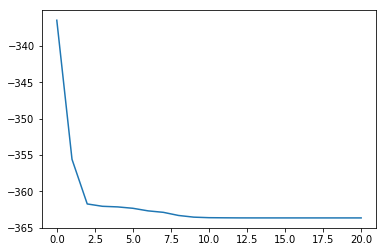

In [26]:
filename = hdf5_pe_output_file_hierarchical
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])    
trajectory

In [27]:
compareResults(hdf5_pe_output_file_hierarchical)

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     1.06620     0.06620     0.06620 p1
1:   0.50000     0.40154    -0.09846    -0.19692 p2
2:   0.40000     0.46443     0.06443     0.16108 p3
3:   2.00000     2.07960     0.07960     0.03980 p4
4:   0.10000     0.06827    -0.03173    -0.31728 p5
5:   2.00000     1.91825    -0.08175    -0.04087 scaling_x1_common
6:   3.00000     2.99600    -0.00400    -0.00133 offset_x2_batch-0
7:   0.20000     0.19761    -0.00239    -0.01197 x1withsigma_sigma
8:   4.00000     2.97014    -1.02986    -0.25746 offset_x2_batch-1

Status: 1
Cost: -363.644100 (expected: -0.000000)


In [28]:
!rm simh.h5
!{example_binary_dir}/example_steadystate_multi_simulator {hdf5_pe_output_file_hierarchical} / simh.h5 / --at-optimum

rm: cannot remove 'simh.h5': No such file or directory
Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Need to compute analytical parameters: //inputData  1 parameters.size() == 5 ; hierarchical.numParameters() == 5
Starting simulation. Number of conditions: 4


In [37]:
(measured, simulated, time, llh) = parpe.readSimulationsFromFile('simh.h5')
start_idx = '0'

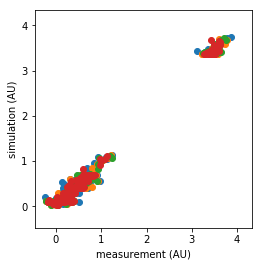

In [46]:
parpe.plotting.plotCorrelation(measured[start_idx], simulated[start_idx])

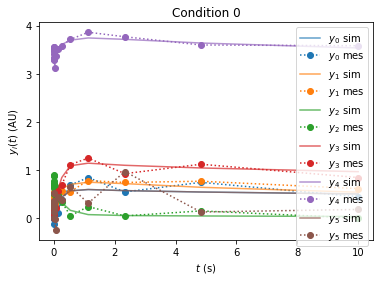

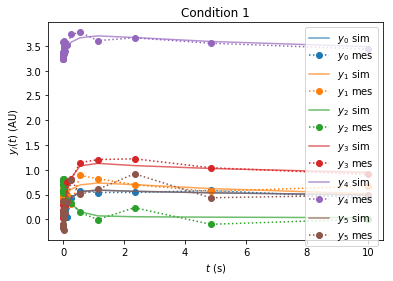

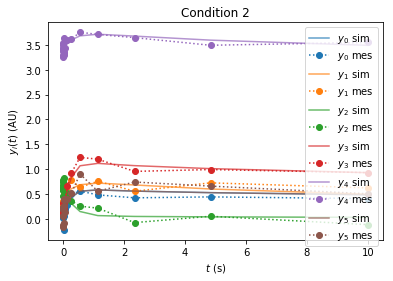

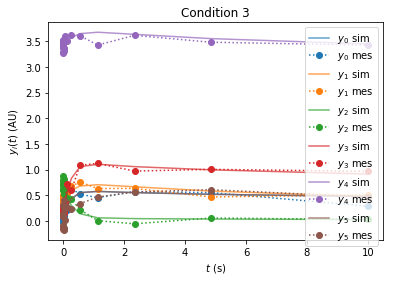

In [48]:
parpe.plotting.plotTrajectoryFits(measured[start_idx], simulated[start_idx], timepoints)

## Ceres

In [50]:
example_data_ceres = f'{example_data_dir}/example_data_ceres.h5'
!cp {example_data_dir}/example_data.h5 {example_data_ceres}
!{optimizationOptionsPy} {example_data_ceres} -s optimizer 1
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemeceres/ {example_data_ceres}


[2019-04-10 15:00:49] [INF] [0/dweindl-ThinkPad-L480] Running with 4 MPI processes.
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-04-10 15:00:49] [INF] [0/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
scalings [ 0.279929 ]
sigmas [ -0.70435 ]
[2019-04-10 15:00:49] [INF] [0/dweindl-ThinkPad-L480] [o0i0] iter: 0 cost: -336.449 time_iter: wall: 0.130572s cpu: 0.396832s time_optim: wall: 0.130573s cpu: 0.396832s
scalings [ 0.271806 ]
sigmas [ -0.562345 ]
scalings [ 0.2785 ]
sig

In [51]:
compareResults('deletemeceres/_rank00000.h5')

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     1.06618     0.06618     0.06618 p1
1:   0.50000     0.40148    -0.09852    -0.19704 p2
2:   0.40000     0.46444     0.06444     0.16110 p3
3:   2.00000     2.07969     0.07969     0.03984 p4
4:   0.10000     0.06825    -0.03175    -0.31752 p5
5:   2.00000     1.91823    -0.08177    -0.04088 scaling_x1_common
6:   3.00000     2.99600    -0.00400    -0.00133 offset_x2_batch-0
7:   0.20000     0.19761    -0.00239    -0.01197 x1withsigma_sigma
8:   4.00000     2.97014    -1.02986    -0.25747 offset_x2_batch-1

Status: 0
Cost: -363.644100 (expected: -0.000000)


## Minibatch optimization

In [52]:
hdf5FileMinibatch = f'{example_data_dir}/example_data_minibatch.h5'
!cp {example_data_dir}/example_data.h5 {hdf5FileMinibatch}

!{optimizationOptionsPy} {hdf5FileMinibatch} -s numStarts 1
!{optimizationOptionsPy} {hdf5FileMinibatch} -s hierarchicalOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s optimizer 10 # minibatch
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/maxEpochs 50
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/batchSize 2
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/parameterUpdater Vanilla
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/Vanilla-learningRate 1e-5
!{optimizationOptionsPy} {hdf5FileMinibatch}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer           10
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

In [53]:
!{parpe_source_root}/misc/selectStartingPoints.py {hdf5FileMinibatch} 9 # select starting point

Creating starting point backup in /optimizationOptions/randomStartsBackup
Selecting starting points [9]


In [54]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o deleteme-minibatch/ {hdf5FileMinibatch}

[2019-04-10 15:01:06] [INF] [0/dweindl-ThinkPad-L480] Running with 4 MPI processes.
[2019-04-10 15:01:06] [INF] [0/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-04-10 15:01:06] [WRN] [0/dweindl-ThinkPad-L480] Ignoring unknown optimization option Vanilla-learningRate.
[2019-04-10 15:01:06] [INF] [0/dweindl-ThinkPad-L480] [o0e0b1] iter: 0 cost: 4796.72 time_iter: wall: 0.115894s cpu: 0.203488s time_optim: wall: 0.115894s cpu: 0.203488s
[2019-04-10 15:01:06] [INF] [0/dweindl-ThinkPad-L480] [o0e1b1] iter: 1 cost: 1309.91 time_iter: wall: 0.047689s cpu: 0.0871196s time_optim: wall: 0.163583s cpu: 0.290608s
[2019-04-10 15:01:06] [INF] [0/dweindl-ThinkPad-L480] [o0e2b1] iter: 2 cost: 2632.8 time_iter: wall: 0.0527614s cpu: 0.0940963s time_optim: wall: 0.216345s cpu: 0.384704s
[2019-04-10 15:01:06] [INF] [0/dweindl-ThinkPad-L480] [o0e3b1] iter: 3 cost: 636.175 time_iter: wall: 0.0515175s cpu: 0.0917324s time_optim: wall: 0.267863s cpu: 0.476

[2019-04-10 15:01:08] [INF] [0/dweindl-ThinkPad-L480] [o0e44b1] iter: 44 cost: -78.6614 time_iter: wall: 0.056107s cpu: 0.0971268s time_optim: wall: 2.24771s cpu: 3.95307s
[2019-04-10 15:01:08] [INF] [0/dweindl-ThinkPad-L480] [o0e45b1] iter: 45 cost: -89.0253 time_iter: wall: 0.0499542s cpu: 0.0889113s time_optim: wall: 2.29767s cpu: 4.04198s
[2019-04-10 15:01:08] [INF] [0/dweindl-ThinkPad-L480] [o0e46b1] iter: 46 cost: -76.2545 time_iter: wall: 0.0492737s cpu: 0.0857121s time_optim: wall: 2.34694s cpu: 4.12769s
[2019-04-10 15:01:08] [INF] [0/dweindl-ThinkPad-L480] [o0e47b1] iter: 47 cost: -76.5049 time_iter: wall: 0.0477723s cpu: 0.0850018s time_optim: wall: 2.39472s cpu: 4.21269s
[2019-04-10 15:01:09] [INF] [0/dweindl-ThinkPad-L480] [o0e48b1] iter: 48 cost: -91.6544 time_iter: wall: 0.0469405s cpu: 0.0833944s time_optim: wall: 2.44166s cpu: 4.29609s
[2019-04-10 15:01:09] [INF] [0/dweindl-ThinkPad-L480] [o0e49b1] iter: 49 cost: -87.9985 time_iter: wall: 0.0484958s cpu: 0.0867953s time

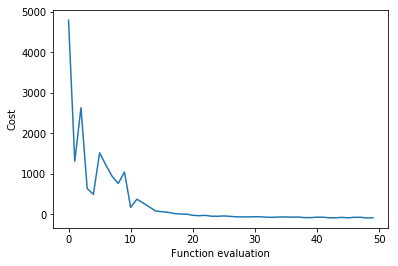

In [55]:
filename = 'deleteme-minibatch/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
    plt.gca().set_xlabel("Function evaluation")
    plt.gca().set_ylabel("Cost")
#trajectory

### Compare learning rates

In [56]:
learningRates = np.logspace(0, -5, 6)
for i, learningRate in enumerate(learningRates):
    curInputFile = "example-data-minibatch-rate-%d.h5" % i
    outprefix = "deleteme-minibatch-rate-%d/" % i
    !cp {hdf5FileMinibatch} {curInputFile}
    !{optimizationOptionsPy} {curInputFile} -s minibatch/Vanilla-learningRate learningRate
    !PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o {outprefix} {hdf5FileMinibatch}

[2019-04-10 15:01:16] [INF] [0/dweindl-ThinkPad-L480] Running with 4 MPI processes.
[2019-04-10 15:01:16] [INF] [0/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-04-10 15:01:16] [WRN] [0/dweindl-ThinkPad-L480] Ignoring unknown optimization option Vanilla-learningRate.
[2019-04-10 15:01:16] [INF] [0/dweindl-ThinkPad-L480] [o0e0b1] iter: 0 cost: 4801.35 time_iter: wall: 0.106505s cpu: 0.179141s time_optim: wall: 0.106506s cpu: 0.179141s
[2019-04-10 15:01:16] [INF] [0/dweindl-ThinkPad-L480] [o0e1b1] iter: 1 cost: 3396.22 time_iter: wall: 0.0595793s cpu: 0.10179s time_optim: wall: 0.166086s cpu: 0.28093s
[2019-04-10 15:01:16] [INF] [0/dweindl-ThinkPad-L480] [o0e2b1] iter: 2 cost: 2591.31 time_iter: wall: 0.0476203s cpu: 0.086449s time_optim: wall: 0.213706s cpu: 0.367379s
[2019-04-10 15:01:16] [INF] [0/dweindl-ThinkPad-L480] [o0e3b1] iter: 3 cost: 2093.91 time_iter: wall: 0.0512557s cpu: 0.0900547s time_optim: wall: 0.264962s cpu: 0.45743

[2019-04-10 15:01:18] [INF] [0/dweindl-ThinkPad-L480] [o0e44b1] iter: 44 cost: -77.5397 time_iter: wall: 0.0478719s cpu: 0.0865507s time_optim: wall: 2.25355s cpu: 3.95585s
[2019-04-10 15:01:18] [INF] [0/dweindl-ThinkPad-L480] [o0e45b1] iter: 45 cost: -89.6782 time_iter: wall: 0.0494629s cpu: 0.08857s time_optim: wall: 2.30302s cpu: 4.04442s
[2019-04-10 15:01:18] [INF] [0/dweindl-ThinkPad-L480] [o0e46b1] iter: 46 cost: -76.9674 time_iter: wall: 0.0514592s cpu: 0.0912396s time_optim: wall: 2.35448s cpu: 4.13566s
[2019-04-10 15:01:18] [INF] [0/dweindl-ThinkPad-L480] [o0e47b1] iter: 47 cost: -75.4278 time_iter: wall: 0.0483408s cpu: 0.0862468s time_optim: wall: 2.40282s cpu: 4.2219s
[2019-04-10 15:01:18] [INF] [0/dweindl-ThinkPad-L480] [o0e48b1] iter: 48 cost: -75.6184 time_iter: wall: 0.0449177s cpu: 0.0802226s time_optim: wall: 2.44774s cpu: 4.30213s
[2019-04-10 15:01:18] [INF] [0/dweindl-ThinkPad-L480] [o0e49b1] iter: 49 cost: -90.644 time_iter: wall: 0.0527335s cpu: 0.091244s time_opt

[2019-04-10 15:01:23] [INF] [0/dweindl-ThinkPad-L480] [o0e36b1] iter: 36 cost: -82.16 time_iter: wall: 0.044408s cpu: 0.0791906s time_optim: wall: 1.80119s cpu: 3.20259s
[2019-04-10 15:01:23] [INF] [0/dweindl-ThinkPad-L480] [o0e37b1] iter: 37 cost: -72.5761 time_iter: wall: 0.046574s cpu: 0.0834735s time_optim: wall: 1.84777s cpu: 3.28607s
[2019-04-10 15:01:23] [INF] [0/dweindl-ThinkPad-L480] [o0e38b1] iter: 38 cost: -74.071 time_iter: wall: 0.0467315s cpu: 0.0829817s time_optim: wall: 1.8945s cpu: 3.36905s
[2019-04-10 15:01:23] [INF] [0/dweindl-ThinkPad-L480] [o0e39b1] iter: 39 cost: -72.2522 time_iter: wall: 0.0458809s cpu: 0.0807586s time_optim: wall: 1.94038s cpu: 3.44981s
[2019-04-10 15:01:23] [INF] [0/dweindl-ThinkPad-L480] [o0e40b1] iter: 40 cost: -73.051 time_iter: wall: 0.0448041s cpu: 0.0803117s time_optim: wall: 1.98518s cpu: 3.53012s
[2019-04-10 15:01:23] [INF] [0/dweindl-ThinkPad-L480] [o0e41b1] iter: 41 cost: -75.5731 time_iter: wall: 0.0437416s cpu: 0.0793693s time_optim

[2019-04-10 15:01:27] [INF] [0/dweindl-ThinkPad-L480] [o0e27b1] iter: 27 cost: -66.388 time_iter: wall: 0.0421772s cpu: 0.0751271s time_optim: wall: 1.36702s cpu: 2.42014s
[2019-04-10 15:01:27] [INF] [0/dweindl-ThinkPad-L480] [o0e28b1] iter: 28 cost: -73.6826 time_iter: wall: 0.0427429s cpu: 0.0769517s time_optim: wall: 1.40976s cpu: 2.4971s
[2019-04-10 15:01:27] [INF] [0/dweindl-ThinkPad-L480] [o0e29b1] iter: 29 cost: -58.1876 time_iter: wall: 0.0424173s cpu: 0.0760643s time_optim: wall: 1.45218s cpu: 2.57316s
[2019-04-10 15:01:27] [INF] [0/dweindl-ThinkPad-L480] [o0e30b1] iter: 30 cost: -63.8349 time_iter: wall: 0.0441031s cpu: 0.077488s time_optim: wall: 1.49628s cpu: 2.65065s
[2019-04-10 15:01:28] [INF] [0/dweindl-ThinkPad-L480] [o0e31b1] iter: 31 cost: -62.2413 time_iter: wall: 0.0425438s cpu: 0.0760448s time_optim: wall: 1.53883s cpu: 2.72669s
[2019-04-10 15:01:28] [INF] [0/dweindl-ThinkPad-L480] [o0e32b1] iter: 32 cost: -67.7277 time_iter: wall: 0.0431966s cpu: 0.0778081s time_o

[2019-04-10 15:01:32] [INF] [0/dweindl-ThinkPad-L480] [o0e18b1] iter: 18 cost: -0.103254 time_iter: wall: 0.0488963s cpu: 0.0836915s time_optim: wall: 0.986214s cpu: 1.77534s
[2019-04-10 15:01:32] [INF] [0/dweindl-ThinkPad-L480] [o0e19b1] iter: 19 cost: -1.37017 time_iter: wall: 0.0434387s cpu: 0.0783549s time_optim: wall: 1.02965s cpu: 1.85369s
[2019-04-10 15:01:32] [INF] [0/dweindl-ThinkPad-L480] [o0e20b1] iter: 20 cost: -40.8641 time_iter: wall: 0.042301s cpu: 0.0761142s time_optim: wall: 1.07195s cpu: 1.92981s
[2019-04-10 15:01:32] [INF] [0/dweindl-ThinkPad-L480] [o0e21b1] iter: 21 cost: -48.6162 time_iter: wall: 0.0428597s cpu: 0.0770795s time_optim: wall: 1.11481s cpu: 2.00689s
[2019-04-10 15:01:32] [INF] [0/dweindl-ThinkPad-L480] [o0e22b1] iter: 22 cost: -46.7395 time_iter: wall: 0.0511024s cpu: 0.0856446s time_optim: wall: 1.16592s cpu: 2.09253s
[2019-04-10 15:01:32] [INF] [0/dweindl-ThinkPad-L480] [o0e23b1] iter: 23 cost: -37.6264 time_iter: wall: 0.0438195s cpu: 0.0786775s ti

[2019-04-10 15:01:37] [INF] [0/dweindl-ThinkPad-L480] [o0e9b1] iter: 9 cost: 595.359 time_iter: wall: 0.0483754s cpu: 0.0873852s time_optim: wall: 0.580903s cpu: 1.03828s
[2019-04-10 15:01:37] [INF] [0/dweindl-ThinkPad-L480] [o0e10b1] iter: 10 cost: 445.498 time_iter: wall: 0.0474488s cpu: 0.0860179s time_optim: wall: 0.628352s cpu: 1.1243s
[2019-04-10 15:01:37] [INF] [0/dweindl-ThinkPad-L480] [o0e11b1] iter: 11 cost: 151.763 time_iter: wall: 0.049256s cpu: 0.0894199s time_optim: wall: 0.677608s cpu: 1.21372s
[2019-04-10 15:01:37] [INF] [0/dweindl-ThinkPad-L480] [o0e12b1] iter: 12 cost: 250.11 time_iter: wall: 0.0468168s cpu: 0.0851558s time_optim: wall: 0.724425s cpu: 1.29888s
[2019-04-10 15:01:37] [INF] [0/dweindl-ThinkPad-L480] [o0e13b1] iter: 13 cost: 292.363 time_iter: wall: 0.0463081s cpu: 0.0845404s time_optim: wall: 0.770734s cpu: 1.38342s
[2019-04-10 15:01:37] [INF] [0/dweindl-ThinkPad-L480] [o0e14b1] iter: 14 cost: 141.92 time_iter: wall: 0.04688s cpu: 0.0846123s time_optim: 

[2019-04-10 15:01:41] [INF] [0/dweindl-ThinkPad-L480] [o0e0b1] iter: 0 cost: 7324.29 time_iter: wall: 0.0618552s cpu: 0.11096s time_optim: wall: 0.0618557s cpu: 0.11096s
[2019-04-10 15:01:41] [INF] [0/dweindl-ThinkPad-L480] [o0e1b1] iter: 1 cost: 3388.84 time_iter: wall: 0.0529853s cpu: 0.0961622s time_optim: wall: 0.114841s cpu: 0.207122s
[2019-04-10 15:01:41] [INF] [0/dweindl-ThinkPad-L480] [o0e2b1] iter: 2 cost: 2603.72 time_iter: wall: 0.0475723s cpu: 0.0872299s time_optim: wall: 0.162414s cpu: 0.294352s
[2019-04-10 15:01:41] [INF] [0/dweindl-ThinkPad-L480] [o0e3b1] iter: 3 cost: 3735.52 time_iter: wall: 0.0495953s cpu: 0.0910506s time_optim: wall: 0.21201s cpu: 0.385402s
[2019-04-10 15:01:41] [INF] [0/dweindl-ThinkPad-L480] [o0e4b1] iter: 4 cost: 502.239 time_iter: wall: 0.0508526s cpu: 0.0930491s time_optim: wall: 0.262862s cpu: 0.478451s
[2019-04-10 15:01:41] [INF] [0/dweindl-ThinkPad-L480] [o0e5b1] iter: 5 cost: 1500.62 time_iter: wall: 0.0504334s cpu: 0.0930636s time_optim: wa

[2019-04-10 15:01:43] [INF] [0/dweindl-ThinkPad-L480] [o0e46b1] iter: 46 cost: -90.2394 time_iter: wall: 0.0515167s cpu: 0.0877037s time_optim: wall: 2.2753s cpu: 4.04989s
[2019-04-10 15:01:43] [INF] [0/dweindl-ThinkPad-L480] [o0e47b1] iter: 47 cost: -88.739 time_iter: wall: 0.0476384s cpu: 0.0853013s time_optim: wall: 2.32294s cpu: 4.13519s
[2019-04-10 15:01:43] [INF] [0/dweindl-ThinkPad-L480] [o0e48b1] iter: 48 cost: -77.5131 time_iter: wall: 0.0461128s cpu: 0.0831823s time_optim: wall: 2.36906s cpu: 4.21837s
[2019-04-10 15:01:44] [INF] [0/dweindl-ThinkPad-L480] [o0e49b1] iter: 49 cost: -75.8784 time_iter: wall: 0.0474197s cpu: 0.0861311s time_optim: wall: 2.41648s cpu: 4.30451s
[2019-04-10 15:01:44] [INF] [0/dweindl-ThinkPad-L480] [o0] Number of epochs exceeded.
[2019-04-10 15:01:44] [INF] [0/dweindl-ThinkPad-L480] [o0] Optimizer status 1, final llh: -8.337445e+01, time: wall: 2.463196 cpu: 4.396601.
[2019-04-10 15:01:45] [INF] [0/dweindl-ThinkPad-L480] Walltime on master: 4.251446s

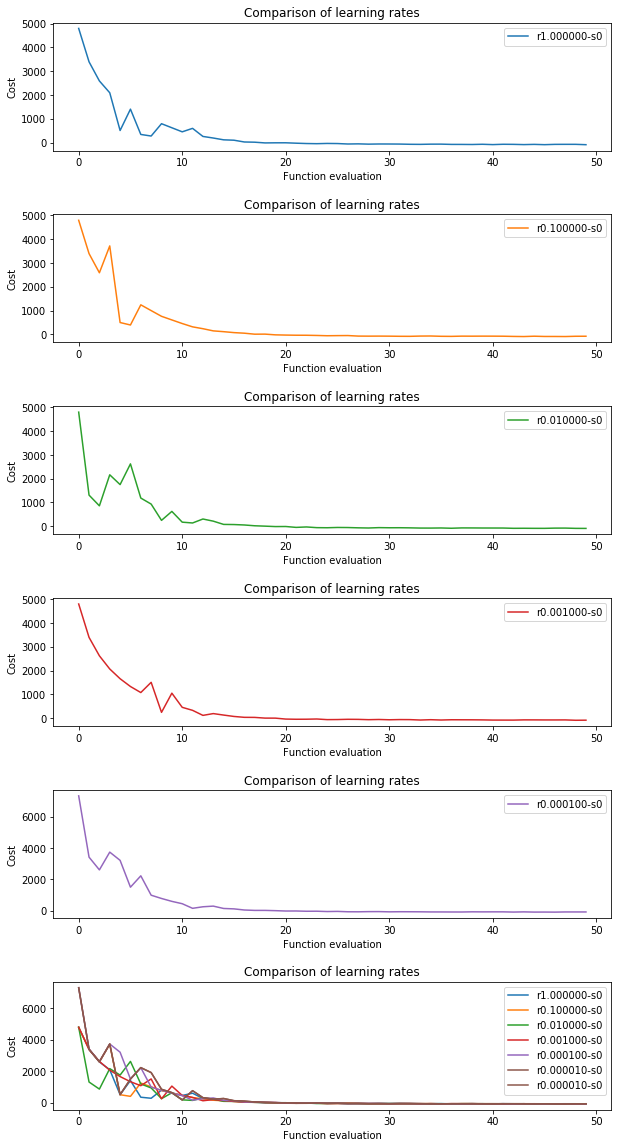

In [57]:
fig, axs = plt.subplots(nrows=len(learningRates + 1), figsize=(10, 20))
for i, learningRate in enumerate(learningRates):
    filename = "deleteme-minibatch-rate-%d/_rank00000.h5" % i
    with h5py.File(filename, 'r') as f:
        trajectory = f['/multistarts/0/iterCostFunCost'][:]
    for start in range(trajectory.shape[0]):
        for ax in (axs[i], axs[-1]):
            ax.plot(trajectory[start], label="r%f-s%d"%(learningRate, start), color="C%d"%i)
            ax.set_xlabel("Function evaluation")
            ax.set_ylabel("Cost")
            ax.set_title("Comparison of learning rates")
            ax.legend()
plt.subplots_adjust(hspace=0.5)